<a href="https://colab.research.google.com/github/Carlosrnes/deep_learning_nova/blob/main/CNN/CNN_Fine_Tuning_Transfer_Learning_ResNet50V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### GPU

https://colab.research.google.com/notebooks/gpu.ipynb

In [1]:
# Check GPU enviroment
!nvidia-smi

Tue Apr 19 08:35:06 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Loading Kaggle Datasets Directly into Google Colab

https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab/ 

In [2]:
# Create access to get food41 dataset from Kaggle
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

# Download data
! kaggle datasets download -d kmader/food41

100% 5.30G/5.30G [00:34<00:00, 196MB/s]
100% 5.30G/5.30G [00:34<00:00, 167MB/s]


### Libraries

In [3]:
import os, shutil, random
import numpy as np
import datetime
import zipfile

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from IPython.display import Image, display

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

from tensorflow.keras import optimizers

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.preprocessing import image
from skimage.io import imread

###  Get Data

In [4]:
# Unzip the downloaded file
zip_ref = zipfile.ZipFile("food41.zip", "r")
zip_ref.extractall()
zip_ref.close()

In [5]:
# select the directory of the images (divided by class folder) - without data augmentation
data_folder = '/content/images'

list_class = os.listdir(data_folder)
list_class.sort()

print(f'{len(list_class)} Classes of foods.')
print(list_class)

101 Classes of foods.
['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheese_plate', 'cheesecake', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese',

### Data Preprocessing

In [6]:
# Set the seed
tf.random.set_seed(42)

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

# train set
train_generator = tf.keras.preprocessing.image_dataset_from_directory(data_folder,
                                         image_size = IMAGE_SHAPE,
                                         batch_size = BATCH_SIZE,
                                         validation_split = 0.2,
                                         label_mode = 'categorical',
                                         seed=42,
                                         subset = 'training')

# validation set
val_generator = tf.keras.preprocessing.image_dataset_from_directory(data_folder,
                                      image_size = IMAGE_SHAPE,
                                      batch_size = BATCH_SIZE,
                                      validation_split = 0.2,
                                      label_mode = 'categorical',
                                      seed=42,
                                      subset = 'validation')

Found 101000 files belonging to 101 classes.
Using 80800 files for training.
Found 101000 files belonging to 101 classes.
Using 20200 files for validation.


In [7]:
# Check
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (32, 224, 224, 3)
labels batch shape: (32, 101)


### Creating a callback function

In [8]:
# Create tensorboard callback (https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard)
def create_tensorboard_callback(dir_name, experiment_name):
  """
  Return log events for TensorBoard
  """ 
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

### Plot function

In [9]:
# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

### Model 1 - Feature extraction model based on ResNet50V2 with data augmentation 

In [10]:
# Build data augmentation layer
data_augmentation = Sequential([
  preprocessing.RandomFlip('horizontal'),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomRotation(0.2),
  preprocessing.Rescaling(1./255) # remove for EfficientNet, keep for ResNet50V2 and others                 
], name="data_augmentation")

# Setup the input shape to our model
input_shape = (224, 224, 3)

# Create a frozen base model for feature extraction
base_model = tf.keras.applications.ResNet50V2(include_top=False)
base_model.trainable = False

# Create input and output layers
inputs = layers.Input(shape=input_shape, name="input_layer") # create input layer
x = data_augmentation(inputs) # augment our training images
x = base_model(x, training=False) # https://keras.io/guides/transfer_learning/#build-a-model 
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x) # https://keras.io/api/layers/pooling_layers/global_average_pooling2d/
outputs = layers.Dense(101, activation="softmax", name="output_layer")(x) # Define the number of labels outputs
model_1 = tf.keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=["accuracy"])

94683136/94668760 [==============================] - 1s 0us/step


In [11]:
# Setup checkpoint path (https://www.tensorflow.org/guide/checkpoint)
checkpoint_path = "model_checkpoints_weights/checkpoint.ckpt"

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True, # set to False to save the entire model
                                                         save_best_only=False, # set to True to save only the best model instead of a model every epoch 
                                                         save_freq="epoch", # save every epoch
                                                         verbose=1)

In [12]:
# Fit the model saving checkpoints every epoch
initial_epochs = 5
feature_extraction_data_aug = model_1.fit(train_generator,
                                          epochs=initial_epochs,
                                          validation_data=val_generator,
                                          validation_steps=len(val_generator),
                                          callbacks=[create_tensorboard_callback("transfer_learning", "model_data_aug"), 
                                          checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/model_data_aug/20220419-083822
Epoch 1/5
2525/2525 [==============================] - ETA: 0s - loss: 2.6452 - accuracy: 0.3725
Epoch 1: saving model to model_checkpoints_weights/checkpoint.ckpt
2525/2525 [==============================] - 1318s 515ms/step - loss: 2.6452 - accuracy: 0.3725 - val_loss: 2.2293 - val_accuracy: 0.4689
Epoch 2/5
2525/2525 [==============================] - ETA: 0s - loss: 2.2813 - accuracy: 0.4493
Epoch 2: saving model to model_checkpoints_weights/checkpoint.ckpt
2525/2525 [==============================] - 912s 361ms/step - loss: 2.2813 - accuracy: 0.4493 - val_loss: 2.1475 - val_accuracy: 0.4925
Epoch 3/5
2525/2525 [==============================] - ETA: 0s - loss: 2.1964 - accuracy: 0.4688
Epoch 3: saving model to model_checkpoints_weights/checkpoint.ckpt
2525/2525 [==============================] - 841s 333ms/step - loss: 2.1964 - accuracy: 0.4688 - val_loss: 2.1386 - val_accuracy: 0.4977
Epoch 4/5
2525

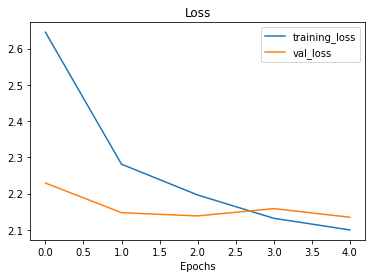

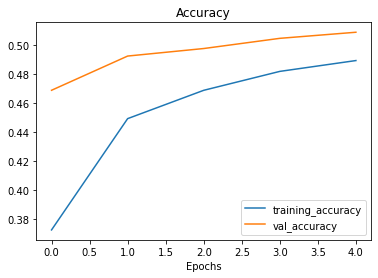

In [13]:
# Plot model loss curves
plot_loss_curves(feature_extraction_data_aug)

In [14]:
# Load in saved model weights and evaluate model
model_1.load_weights(checkpoint_path)
loaded_weights_model_results = model_1.evaluate(val_generator)

632/632 [==============================] - 119s 187ms/step - loss: 2.1350 - accuracy: 0.5089


In [15]:
# Layers in loaded model
model_1.layers

In [16]:
# Verifing wich layers are frozen
for layer in model_1.layers:
  print(layer.trainable)

True
True
False
True
True


In [17]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 resnet50v2 (Functional)     (None, None, None, 2048)  23564800  
                                                                 
 global_average_pooling_laye  (None, 2048)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 101)               206949    
                                                                 
Total params: 23,771,749
Trainable params: 206,949
Non-traina

### Model 2 - Feature extracting and fine-tuning ResNet50V2 with data augmentation

In [18]:
# Change base model to not frozen
base_model.trainable = True

# Freeze all layers except for the 10 last
for layer in base_model.layers[:-10]:
  layer.trainable = False

# Recompile the model
model_1.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=["accuracy"]) # learning rate is 10x lower than before for fine-tuning

In [19]:
# Check which layers are tuneable (trainable)
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 conv1_pad False
2 conv1_conv False
3 pool1_pad False
4 pool1_pool False
5 conv2_block1_preact_bn False
6 conv2_block1_preact_relu False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_pad False
11 conv2_block1_2_conv False
12 conv2_block1_2_bn False
13 conv2_block1_2_relu False
14 conv2_block1_0_conv False
15 conv2_block1_3_conv False
16 conv2_block1_out False
17 conv2_block2_preact_bn False
18 conv2_block2_preact_relu False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_pad False
23 conv2_block2_2_conv False
24 conv2_block2_2_bn False
25 conv2_block2_2_relu False
26 conv2_block2_3_conv False
27 conv2_block2_out False
28 conv2_block3_preact_bn False
29 conv2_block3_preact_relu False
30 conv2_block3_1_conv False
31 conv2_block3_1_bn False
32 conv2_block3_1_relu False
33 conv2_block3_2_pad False
34 conv2_block3_2_conv False
35 conv2_block3_2_bn False
36 conv2_bloc

In [20]:
# Fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5

# Refit the model (same as model_1 except with 10 more trainable layers)
model_fine_data_aug = model_1.fit(train_generator,
                                  epochs=fine_tune_epochs,
                                  validation_data=val_generator,
                                  initial_epoch=feature_extraction_data_aug.epoch[-1], # start from previous last epoch
                                  validation_steps=len(val_generator),
                                  callbacks=[create_tensorboard_callback("transfer_learning", "fine_tune_feature_extracting")]) # name experiment appropriately


Saving TensorBoard log files to: transfer_learning/fine_tune_feature_extracting/20220419-095931
Epoch 5/10
2525/2525 [==============================] - 779s 306ms/step - loss: 1.8679 - accuracy: 0.5272 - val_loss: 1.7714 - val_accuracy: 0.5637
Epoch 6/10
2525/2525 [==============================] - 748s 296ms/step - loss: 1.7283 - accuracy: 0.5565 - val_loss: 1.7180 - val_accuracy: 0.5723
Epoch 7/10
2525/2525 [==============================] - 733s 290ms/step - loss: 1.6302 - accuracy: 0.5782 - val_loss: 1.6774 - val_accuracy: 0.5789
Epoch 8/10
2525/2525 [==============================] - 722s 286ms/step - loss: 1.5556 - accuracy: 0.5940 - val_loss: 1.6491 - val_accuracy: 0.5900
Epoch 9/10
2525/2525 [==============================] - 719s 284ms/step - loss: 1.4912 - accuracy: 0.6090 - val_loss: 1.6920 - val_accuracy: 0.5871
Epoch 10/10
2525/2525 [==============================] - 711s 282ms/step - loss: 1.4463 - accuracy: 0.6186 - val_loss: 1.6642 - val_accuracy: 0.5935


In [21]:
# Function compares two model history objects

def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two model history objects.
    """
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    print(len(acc))

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    print(len(total_acc))
    print(total_acc)

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

5
11
[0.3724752366542816, 0.449282169342041, 0.46883663535118103, 0.4818935692310333, 0.48936882615089417, 0.5272029638290405, 0.5564727783203125, 0.5782178044319153, 0.594022274017334, 0.6089851260185242, 0.6185891032218933]


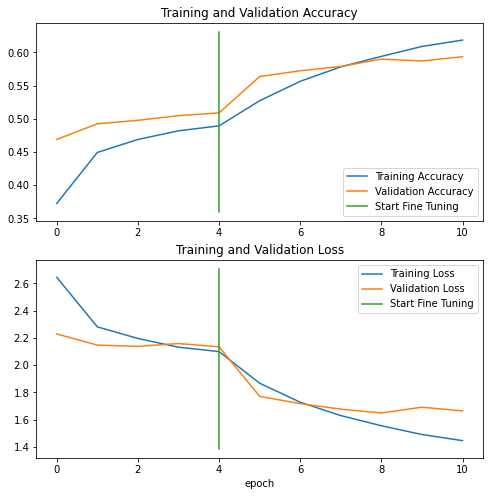

In [22]:
compare_historys(original_history=feature_extraction_data_aug, 
                 new_history=model_fine_data_aug, 
                 initial_epochs=5)

### Save the model

In [23]:
# # Save model so it can be used later 
model_1.save("/content/model_tf/model_ResNEt50V2_FineTuning", save_format='h5')

### Load the model

In [24]:
# Load Model
model = tf.keras.models.load_model("/content/model_tf/model_ResNEt50V2_FineTuning")

In [25]:
# Check to see if loaded model is a trained model
loaded_loss, loaded_accuracy = model.evaluate(val_generator)
loaded_loss, loaded_accuracy

632/632 [==============================] - 122s 189ms/step - loss: 1.6642 - accuracy: 0.5935


(1.664178490638733, 0.5935148596763611)

In [26]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 resnet50v2 (Functional)     (None, None, None, 2048)  23564800  
                                                                 
 global_average_pooling_laye  (None, 2048)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 101)               206949    
                                                                 
Total params: 23,771,749
Trainable params: 3,623,013
Non-trai

### Making predictions

In [27]:
# Get the class names
class_names = val_generator.class_names
class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [28]:
# Make predictions with model
pred_probs = model.predict(val_generator, verbose=1)

632/632 [==============================] - 115s 180ms/step


In [29]:
# Check to see if loaded model is a trained model
loaded_loss, loaded_accuracy = model.evaluate(val_generator)
loaded_loss, loaded_accuracy

632/632 [==============================] - 118s 186ms/step - loss: 1.6642 - accuracy: 0.5935


(1.6641793251037598, 0.5935148596763611)

In [30]:
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (224, 224, 3).

  Parameters
  ----------
  filename (str): string filename of target image
  img_shape (int): size to resize target image to, default 224
  scale (bool): whether to scale pixel values to range(0, 1), default True
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.io.decode_image(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img

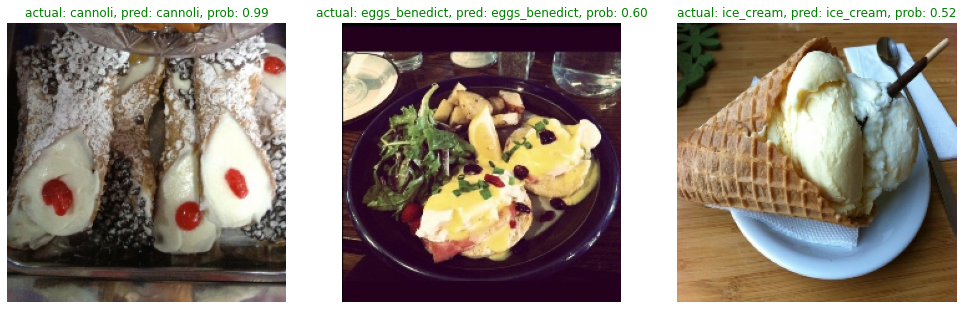

In [31]:
# Make preds on a series of random images

plt.figure(figsize=(17, 10))
for i in range(3):
  # Choose a random image from a random class 
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir("/content/images/" + class_name))
  filepath = "/content/images/" + class_name + "/" + filename

  # Load the image and make predictions
  img = load_and_prep_image(filepath, scale=False) # don't scale images for EfficientNet predictions
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # model accepts tensors of shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class 

  # Plot the image(s)
  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class: # Change the color of text based on whether prediction is right or wrong
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);

### Test out the model

In [32]:
# Connect google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [33]:
# Get custom food images filepaths
custom_food_images = ["/content/drive/MyDrive/DL Photo Data/allrecipes/" + img_path for img_path 
                      in os.listdir("/content/drive/MyDrive/DL Photo Data/allrecipes/")]
custom_food_images

['/content/drive/MyDrive/DL Photo Data/allrecipes/9ca9adfae4a04ecf8ac3275fcef25e7b.png',
 '/content/drive/MyDrive/DL Photo Data/allrecipes/Thumb_A.jpg',
 '/content/drive/MyDrive/DL Photo Data/allrecipes/963e246e6b1a4454ad1443106fa81ef5.png',
 '/content/drive/MyDrive/DL Photo Data/allrecipes/thumb1.jpg',
 '/content/drive/MyDrive/DL Photo Data/allrecipes/b45c92448f0a4a8791895420b3742feb.png',
 '/content/drive/MyDrive/DL Photo Data/allrecipes/7fec3061736045b79732e9dadd799fb9.jpeg',
 '/content/drive/MyDrive/DL Photo Data/allrecipes/80652d5ee9084ad89008ac33d9a8c40e.png',
 '/content/drive/MyDrive/DL Photo Data/allrecipes/364998.jpg',
 '/content/drive/MyDrive/DL Photo Data/allrecipes/370269.jpg',
 '/content/drive/MyDrive/DL Photo Data/allrecipes/191988.jpg',
 '/content/drive/MyDrive/DL Photo Data/allrecipes/6ec7eccca8734817b59c3e81f55bd2ee.jpeg',
 '/content/drive/MyDrive/DL Photo Data/allrecipes/e6090e770eff40d09bb74530f5000b53.jpeg',
 '/content/drive/MyDrive/DL Photo Data/allrecipes/BFV10386

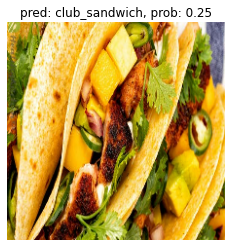

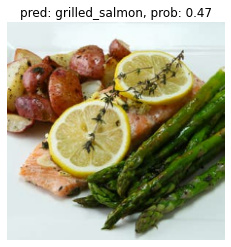

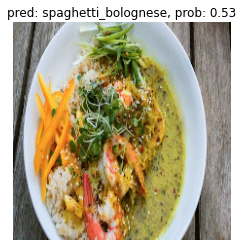

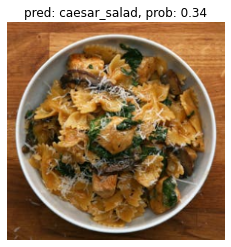

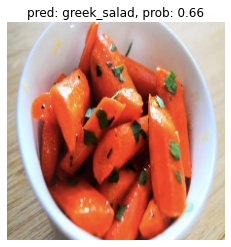

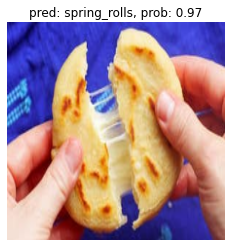

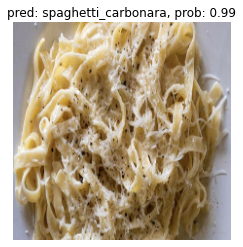

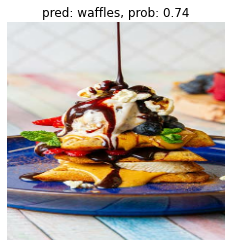

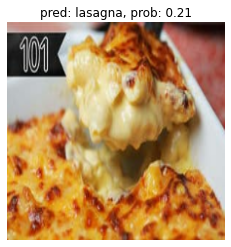

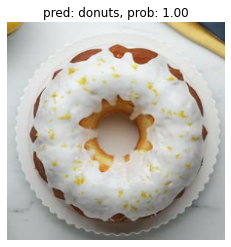

In [34]:
# Make predictions on custom food images
for img in custom_food_images[:10]:
  img = load_and_prep_image(img, scale=False) # load in target image and turn it into tensor
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # make prediction on image with shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class label
  # Plot the image with appropriate annotations
  plt.figure()
  plt.imshow(img/255.) # imshow() requires float inputs to be normalized
  plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
  plt.axis(False)

### The Grad-CAM algorithm

In [35]:
# loading the pretrained model - EfficientNetB0 to apply the heatmap
base_model = tf.keras.applications.ResNet50V2(weights='imagenet')

102883328/102869336 [==============================] - 1s 0us/step


In [36]:
# https://keras.io/examples/vision/grad_cam/

# function to get the image and transform it into an array
def get_img_array(img_path, size):
    # `img` is a PIL image of size 224x224
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (224, 224, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


# function to create the grad-cam heatmap
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


# function to overlap the heatmap and the real image
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))

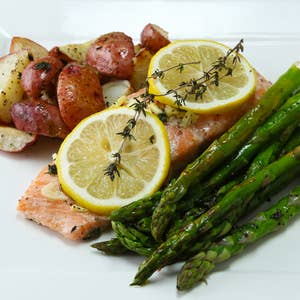

In [37]:
# Test in one image prediction

# The local path to our target image
img_path = '/content/drive/MyDrive/DL Photo Data/allrecipes/Thumb_A.jpg'

# display the image with the training size
display(Image(filename=img_path, width=224, height=224))

Predicted class: grilled_salmon


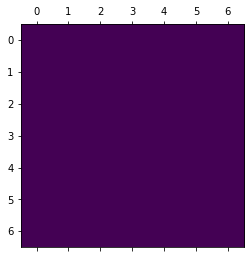

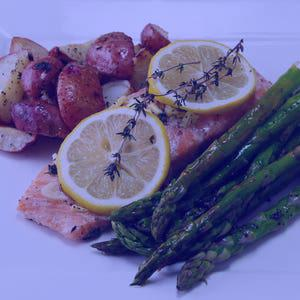

In [40]:
# Apply the Grad-CAM Algorithm

# prepare image
img_size = (224,224)
img_array = get_img_array(img_path, size=img_size)

# Print the predicted class
preds = model.predict(img_array)
print("Predicted class:", list_class[np.argmax(preds[0])])

# define the last CNN layer - name from base_model.summary() - EfficientNetB0 
last_conv_layer_name = 'conv5_block3_3_conv'

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, base_model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

save_and_display_gradcam(img_path, heatmap)

101
Predicted: fried_calamari


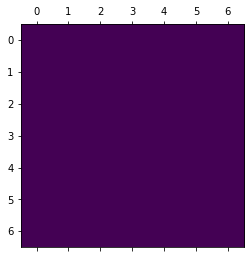

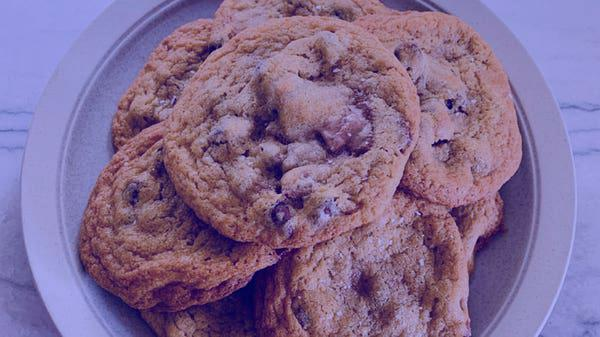

In [41]:
# Test in one image prediction

# The local path to our target image
img_path = '/content/drive/MyDrive/DL Photo Data/allrecipes/6ec7eccca8734817b59c3e81f55bd2ee.jpeg'

# Prepare image
img_size = (224,224)
img_array = get_img_array(img_path, size=img_size)

# Print what the top predicted class is
preds = model.predict(img_array)
print(len(preds[0]))
print("Predicted:", list_class[np.argmax(preds[0])])

# name form model.summary() of the last CNN layer
last_conv_layer_name = 'conv5_block3_3_conv'

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, base_model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

save_and_display_gradcam(img_path, heatmap)

101
Predicted: macarons


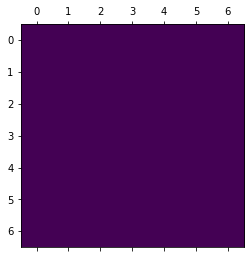

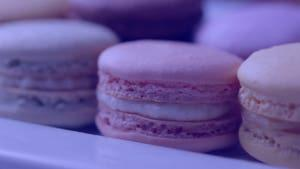

In [42]:
# Test in one image prediction

# The local path to our target image
img_path = '/content/drive/MyDrive/DL Photo Data/allrecipes/BFV37854_TheMostFoolProofMacaronsYoullEverMake_KP_121819_YT.jpg'

# Prepare image
img_size = (224,224)
img_array = get_img_array(img_path, size=img_size)

# Print what the top predicted class is
preds = model.predict(img_array)
print(len(preds[0]))
print("Predicted:", list_class[np.argmax(preds[0])])

# name form model.summary() of the last CNN layer
last_conv_layer_name = 'conv5_block3_3_conv'

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, base_model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

save_and_display_gradcam(img_path, heatmap)